In [72]:
#!pip install gplearn
#!pip install xgboost
#!pip install lightgbm

In [260]:
# 기본 라이브러리 import
import pandas as pd
import numpy as np
from datetime import * 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import PolyCollection
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) 

import re
import urllib.request
import calendar
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 모델링 라이브러리 import
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance, plot_tree
from gplearn.genetic import SymbolicRegressor
from keras.layers import LSTM 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
import tensorflow as tf

### 1. 데이터 로드 및 전처리

#### 1) 날씨데이터

In [75]:
# 데이터 불러오기
weather = pd.read_csv('weather_daily_darksky.csv')

# na가 있는 행 삭제
# weather = weather.dropna()

# 'High'와 'Low'가 있는 컬럼 삭제
weather_col = list(weather.columns)
highlowlist = []
for word in weather_col:
    if 'High' in word:
        highlowlist.append(word)
    elif 'Low' in word:
        highlowlist.append(word)
weather = weather.drop(highlowlist, axis=1)

# 의미를 알 수 없는 'time' 변수 삭제
# 'summary' 변수 삭제
weather = weather.drop(['time','summary'], axis=1)

# 'Time'이 있는 변수명만 리스트로 받기
weather_col = list(weather.columns)
timelist = []
for word in weather_col:
    if 'Time' in word:
        timelist.append(word)

# time 변수를 datetime으로 타입 변환 
for word in timelist:
    weather[word] = pd.to_datetime(weather[word])

# 날짜만 있는 'date' 변수 생성
weather['date'] = weather['sunsetTime'].dt.date

# 'Time' 변수에 시간만 남겨두고 날짜 삭제
for word in timelist:
    weather[word] = weather[word].dt.time

# 'date' 변수를 제일 앞으로
col1 = [weather.columns[-1]]
col2 = list(weather.columns[:-1])
new_col = col1 + col2
weather = weather[new_col]

# 'date' 기준으로 정렬
weather = weather.sort_values(by=['date'], axis=0)

# na가 있는 행 채우기
weather['cloudCover'] = weather['cloudCover'].fillna(round((0.59+0.4)/2,2)) # 앞뒤날짜로 채워넣기
weather['uvIndex'] = weather['uvIndex'].fillna(1) # 2012,2013년 1월 1일과 동일하게 채우기
weather['uvIndexTime'] = weather['uvIndexTime'].fillna(time(11,0)) # 2012,2013년 1월 1일과 동일하게 채우기
#weather = weather.reset_index(drop=True)
# 'weather.csv' 저장
# weather.to_csv('weather.csv', index=False, encoding='utf-8') 

#### 2) 날씨 데이터와 에너지 데이터 병합

In [76]:
# 날씨 데이터 load
#weather = pd.read_csv("weather.csv")
weather.head()

,date,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,...,humidity,apparentTemperatureMax,uvIndex,sunsetTime,temperatureMin,sunriseTime,uvIndexTime,apparentTemperatureMin,apparentTemperatureMaxTime,moonPhase
13,2011-11-01,15.57,15:00:00,208,partly-cloudy-day,10.13,22:00:00,0.36,2.45,1009.46,...,0.84,15.57,1.0,16:36:03,9.68,06:54:29,10:00:00,9.01,15:00:00,0.21
60,2011-11-02,15.19,23:00:00,134,partly-cloudy-night,10.23,03:00:00,0.39,4.39,1004.79,...,0.87,15.19,1.0,16:34:15,8.88,06:56:16,09:00:00,7.33,23:00:00,0.24
34,2011-11-03,17.41,14:00:00,154,partly-cloudy-day,13.39,21:00:00,0.52,3.99,993.40,...,0.89,17.41,1.0,16:32:29,12.79,06:58:03,10:00:00,12.79,14:00:00,0.27
31,2011-11-04,15.54,11:00:00,179,fog,12.03,23:00:00,0.50,2.62,995.54,...,0.91,15.54,1.0,16:30:44,11.53,06:59:49,10:00:00,11.53,11:00:00,0.31
46,2011-11-05,13.94,15:00:00,346,fog,10.96,02:00:00,0.65,2.70,1007.39,...,0.92,13.94,1.0,16:29:01,10.17,07:01:36,10:00:00,10.17,15:00:00,0.34


In [77]:
# block별로 나눠져 있는 energy 데이터를 하나로 통합
energy = pd.read_csv('./daily_dataset/block_0.csv')[['LCLid', 'day', 'energy_sum']]
for i in range(1, 112):
    df = pd.read_csv("./daily_dataset/block_"+str(i)+".csv")[['LCLid', 'day', 'energy_sum']]
    energy = pd.concat([energy, df], axis=0)

energy.head()

,LCLid,day,energy_sum
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [78]:
# 일별 총 에너지소비량에 대한 데이터로 변경
energy = energy.groupby(['day'], as_index=False).sum().rename(columns={'day':'date', 'energy_sum':'energyuse'})
energy.head()

,date,energyuse
0,2011-11-23,90.385000
1,2011-11-24,213.412000
2,2011-11-25,303.993000
3,2011-11-26,420.976000
4,2011-11-27,444.883001


In [108]:
# 에너지사용량 데이터와 날씨 데이터 병합
energy['date'] = pd.to_datetime(energy['date'], format="%Y-%m-%d")
weather['date'] = pd.to_datetime(weather['date'], format="%Y-%m-%d")
data = pd.merge(energy, weather, on="date", how="left")
data

,date,energyuse,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,...,humidity,apparentTemperatureMax,uvIndex,sunsetTime,temperatureMin,sunriseTime,uvIndexTime,apparentTemperatureMin,apparentTemperatureMaxTime,moonPhase
0,2011-11-23,90.385000,10.36,14:00:00,229,fog,6.29,07:00:00,0.36,2.04,...,0.93,10.36,1.0,16:03:50,3.81,07:32:38,10:00:00,2.18,14:00:00,0.94
1,2011-11-24,213.412000,12.93,12:00:00,204,partly-cloudy-night,8.56,02:00:00,0.41,4.04,...,0.89,12.93,1.0,16:02:48,8.56,07:34:14,10:00:00,7.01,12:00:00,0.97
2,2011-11-25,303.993000,13.03,05:00:00,243,partly-cloudy-day,7.24,23:00:00,0.48,5.02,...,0.79,13.03,1.0,16:01:49,7.46,07:35:49,10:00:00,4.84,05:00:00,0.01
3,2011-11-26,420.976000,12.96,14:00:00,237,wind,6.96,01:00:00,0.44,5.75,...,0.81,12.96,1.0,16:00:53,7.01,07:37:22,10:00:00,4.69,14:00:00,0.05
4,2011-11-27,444.883001,13.54,10:00:00,256,wind,5.76,23:00:00,0.42,5.48,...,0.72,13.54,1.0,16:00:00,4.47,07:38:54,10:00:00,2.94,10:00:00,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,51994.547004,14.23,13:00:00,183,wind,6.03,07:00:00,0.50,5.02,...,0.74,14.23,1.0,17:32:15,7.99,06:58:05,09:00:00,5.52,13:00:00,0.82
825,2014-02-25,51423.508001,11.43,00:00:00,202,partly-cloudy-day,5.06,21:00:00,0.62,5.69,...,0.78,11.43,1.0,17:34:02,6.79,06:55:59,09:00:00,3.89,00:00:00,0.86
826,2014-02-26,50943.305995,11.29,13:00:00,227,partly-cloudy-day,2.74,07:00:00,0.26,3.82,...,0.73,11.29,2.0,17:35:49,4.17,06:53:52,12:00:00,1.67,13:00:00,0.90
827,2014-02-27,51678.185998,10.31,14:00:00,224,partly-cloudy-day,3.08,23:00:00,0.32,4.14,...,0.74,10.31,2.0,17:37:35,3.93,06:51:45,12:00:00,1.41,14:00:00,0.93


In [ ]:
#data.to_csv("data.csv", index=False)

#### 3) 전처리

In [ ]:
#data=pd.read_csv('data.csv')

In [123]:
# 날짜 변수 & 필요없는 변수 제거
#data=data.drop(['date','apparentTemperatureMinTime','uvIndexTime','apparentTemperatureMaxTime'],axis=1)

# 최고온도시간과 최저온도시간 차이, 일몰시간과 일출시간의 차이에 대한 변수 생성
temperature_MaxMin_diff = []
sunset_sunrise_diff = []
for i in range(len(data)) :
    temperature_MaxMin_diff.append(abs(pd.to_numeric(str(data.temperatureMaxTime[i]).split(':')[0])-pd.to_numeric(str(data.temperatureMinTime[i]).split(':')[0])))
    sunset_sunrise_diff.append(abs(pd.to_numeric(str(data.sunsetTime[i]).split(':')[0])-pd.to_numeric(str(data.sunriseTime[i]).split(':')[0])))

data['temperature_MaxMin_diff'] = temperature_MaxMin_diff
data['sunset_sunrise_diff'] = sunset_sunrise_diff

# Time 관련 변수들 제거
data=data.drop(['temperatureMaxTime','temperatureMinTime','sunsetTime','sunriseTime'],axis=1)
data.head()

,energyuse,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,precipType,visibility,humidity,apparentTemperatureMax,uvIndex,temperatureMin,apparentTemperatureMin,moonPhase,temperature_MaxMin_diff,sunset_sunrise_diff
0,90.385000,10.36,229,fog,6.29,0.36,2.04,1027.12,rain,8.06,0.93,10.36,1.0,3.81,2.18,0.94,7,9
1,213.412000,12.93,204,partly-cloudy-night,8.56,0.41,4.04,1027.22,rain,10.64,0.89,12.93,1.0,8.56,7.01,0.97,10,9
2,303.993000,13.03,243,partly-cloudy-day,7.24,0.48,5.02,1024.47,rain,12.38,0.79,13.03,1.0,7.46,4.84,0.01,18,9
3,420.976000,12.96,237,wind,6.96,0.44,5.75,1025.80,rain,13.07,0.81,12.96,1.0,7.01,4.69,0.05,13,9
4,444.883001,13.54,256,wind,5.76,0.42,5.48,1021.11,rain,13.08,0.72,13.54,1.0,4.47,2.94,0.08,13,9


In [124]:
#one_hot_encoding
one_hot_data=pd.get_dummies(data[['precipType','icon']])
data=pd.concat([data,one_hot_data],axis=1)
data=data.drop(['icon','precipType'],axis=1)

#MinMax scaling
MinMax= MinMaxScaler()
MinMax.fit(data[['temperatureMax','windBearing','dewPoint','cloudCover','windSpeed','pressure','visibility','humidity','apparentTemperatureMax','temperatureMin','apparentTemperatureMin','temperature_MaxMin_diff','sunset_sunrise_diff']])

# Pipeline
num_attribs=['temperatureMax','windBearing','dewPoint','cloudCover','windSpeed','pressure','visibility','humidity','apparentTemperatureMax','temperatureMin','apparentTemperatureMin','temperature_MaxMin_diff','sunset_sunrise_diff'] #수치형 열이름 list

full_pipeline=ColumnTransformer([
    ('num',MinMaxScaler(),num_attribs), ])

data_scaled=full_pipeline.fit_transform(data)  #밀집행렬이 반환됨

#최종 데이터 final_data 생성
data1=pd.DataFrame(data_scaled)
data1.columns=['temperatureMax','windBearing','dewPoint','cloudCover','windSpeed','pressure','visibility','humidity','apparentTemperatureMax','temperatureMin','apparentTemperatureMin','temperature_MaxMin_diff','sunset_sunrise_diff']
data2=data.iloc[:,16:]
final_data=pd.concat([data1,data2],axis=1)
final_data['energyuse']=data['energyuse']

In [ ]:
#final_data.to_csv("timeSeries_final.csv",index=False)

In [125]:
#final_data=pd.read_csv('timeSeries_final.csv')[:-1]  # 맨 마지막 데이터는 제외
final_data

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,apparentTemperatureMax,temperatureMin,...,sunset_sunrise_diff,precipType_rain,precipType_snow,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_wind,energyuse
0,0.321010,0.637883,0.551738,0.36,0.188525,0.776228,0.474747,0.909091,0.396113,0.360963,...,0.2,1,0,0,0,1,0,0,0,90.385000
1,0.400185,0.568245,0.640375,0.41,0.393443,0.777850,0.660895,0.836364,0.466466,0.542399,...,0.2,1,0,0,0,0,0,1,0,213.412000
2,0.403266,0.676880,0.588832,0.48,0.493852,0.733258,0.786436,0.654545,0.469203,0.500382,...,0.2,1,0,0,0,0,1,0,0,303.993000
3,0.401109,0.660167,0.577899,0.44,0.568648,0.754824,0.836219,0.690909,0.467287,0.483193,...,0.2,1,0,0,0,0,0,0,1,420.976000
4,0.418977,0.713092,0.531043,0.42,0.540984,0.678774,0.836941,0.527273,0.483165,0.386173,...,0.2,1,0,0,0,0,0,0,1,444.883001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,0.440234,0.509749,0.541585,0.50,0.493852,0.420626,0.831169,0.563636,0.502053,0.520626,...,0.4,1,0,0,0,0,0,0,1,51994.547004
825,0.353974,0.562674,0.503709,0.62,0.562500,0.347008,0.765512,0.636364,0.425404,0.474790,...,0.4,1,0,0,0,0,1,0,0,51423.508001
826,0.349661,0.632312,0.413120,0.26,0.370902,0.542890,0.831169,0.545455,0.421571,0.374714,...,0.4,1,0,0,0,0,1,0,0,50943.305995
827,0.319470,0.623955,0.426396,0.32,0.403689,0.450300,0.761905,0.563636,0.394744,0.365546,...,0.4,1,0,0,0,0,1,0,0,51678.185998


### 2. EDA

In [126]:
df = pd.read_csv("weather_daily_darksky.csv")
df['sunriseTime'] = pd.to_datetime(df['sunriseTime'])
df['date'] = df['sunriseTime'].dt.date
df = df.sort_values(by='date' ,ascending=True)

#### 온도 중 Max와 High의 차이가 없음을 보여주기 위한 그래프

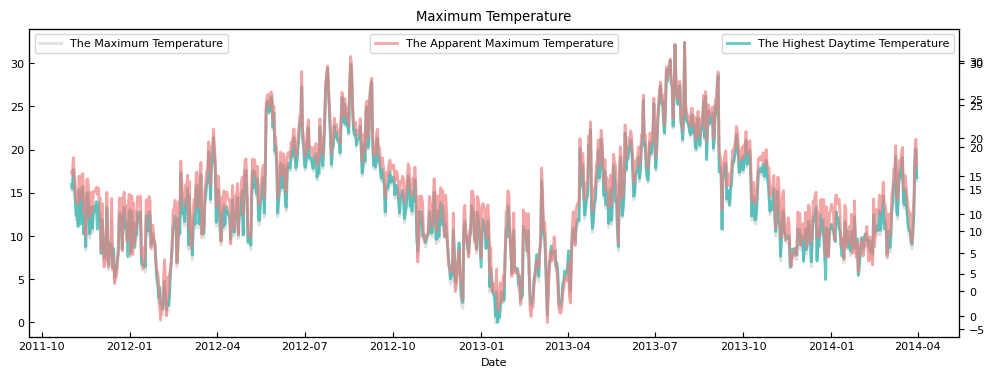

In [127]:
# 1. 기본 스타일 설정
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['font.size'] = 8

# 2. 데이터 준비
x = np.array(list(df['date']))
y1 = np.array(list(df['temperatureMax']))
y2 = np.array(list(df['temperatureHigh']))
y3 = np.array(list(df['apparentTemperatureMax']))

# 3. 그래프 그리기
fig, ax1 = plt.subplots()

ax1.plot(x, y1, color='lightgrey', markersize=3, linewidth=2, alpha=0.7, label='The Maximum Temperature')
ax1.set_xlabel('Date')
ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='lightseagreen', markersize=3, linewidth=2, alpha=0.7, label='The Highest Daytime Temperature')

ax3 = ax1.twinx()
ax3.plot(x, y3, color='lightcoral', markersize=3, linewidth=2, alpha=0.7, label='The Apparent Maximum Temperature')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper center')

plt.title('Maximum Temperature')
plt.show()

#### 온도 중 Min과 Low의 차이가 없음을 보여주기 위한 그래프

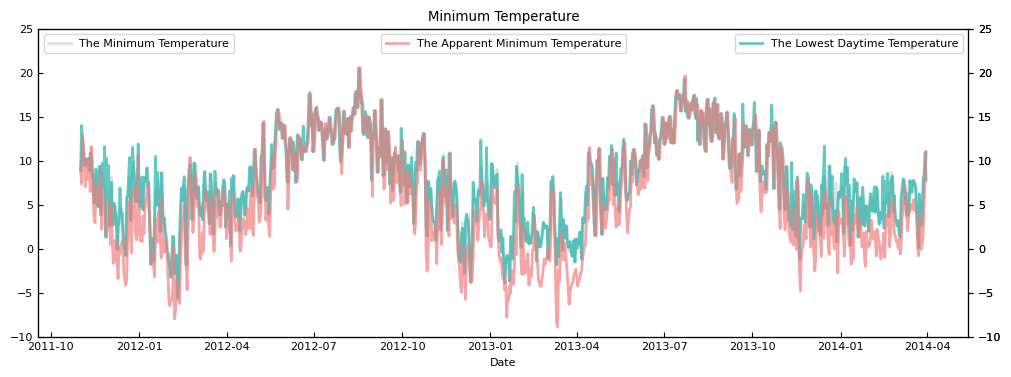

In [128]:
# 1. 기본 스타일 설정
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['font.size'] = 8

# 2. 데이터 준비
x = np.array(list(df['date']))
y1 = np.array(list(df['temperatureMin']))
y2 = np.array(list(df['temperatureLow']))
y3 = np.array(list(df['apparentTemperatureMin']))

# 3. 그래프 그리기
fig, ax1 = plt.subplots()

ax1.plot(x, y1, color='lightgrey', markersize=3, linewidth=2, alpha=0.7, label='The Minimum Temperature')
ax1.set_xlabel('Date')
ax1.tick_params(axis='both', direction='in')
plt.ylim(-10,25)

ax2 = ax1.twinx()
ax2.plot(x, y2, color='lightseagreen', markersize=3, linewidth=2, alpha=0.7, label='The Lowest Daytime Temperature')
plt.ylim(-10,25)

ax3 = ax1.twinx()
ax3.plot(x, y3, color='lightcoral', markersize=3, linewidth=2, alpha=0.7, label='The Apparent Minimum Temperature')
plt.ylim(-10,25)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper center')

plt.title('Minimum Temperature')
plt.show()

#### 날짜 변수와 energyuse

In [129]:
data = pd.read_csv("data.csv")
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['weekday'] = data['date'].dt.weekday

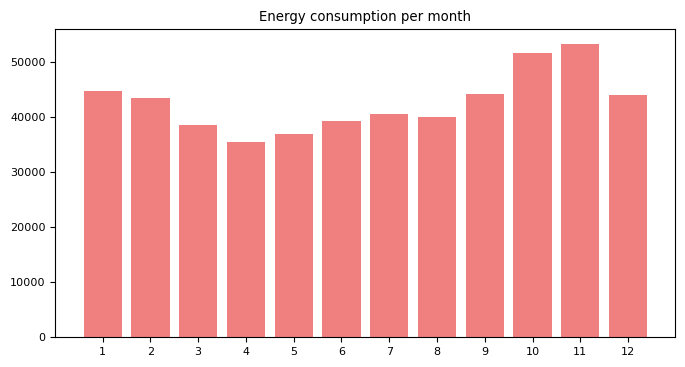

In [130]:
# 월별 에너지소비 평균
plt.figure(figsize = (8,4))
plt.bar(np.arange(12), list(data[['month','energyuse']].groupby(['month']).mean()['energyuse']), color = "lightcoral")
plt.xticks(np.arange(12), list(data[['month','energyuse']].groupby(['month']).mean().index))
plt.title('Energy consumption per month')
plt.show()

In [131]:
data_weekend = data[(data['weekday'] == 5) | (data['weekday'] == 6)]
data_notweekend = data[(data['weekday'] == 0) | (data['weekday'] == 1) | (data['weekday'] == 2) | (data['weekday'] == 3) | (data['weekday'] == 4)]

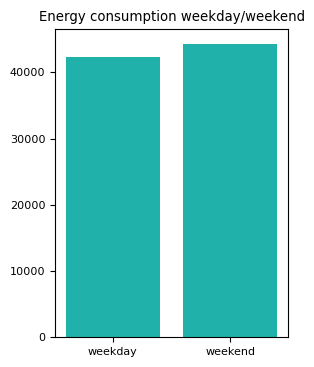

In [132]:
# 주말여부 별 에너지 소비량
plt.figure(figsize = (3,4))
x = np.arange(2)
day = ['weekday', 'weekend']
values = [data_notweekend['energyuse'].mean(), data_weekend['energyuse'].mean()]

plt.bar(x, values, color = "lightseagreen")
plt.xticks(x, day)
plt.title("Energy consumption weekday/weekend")

plt.show()

#### 이상치 제거

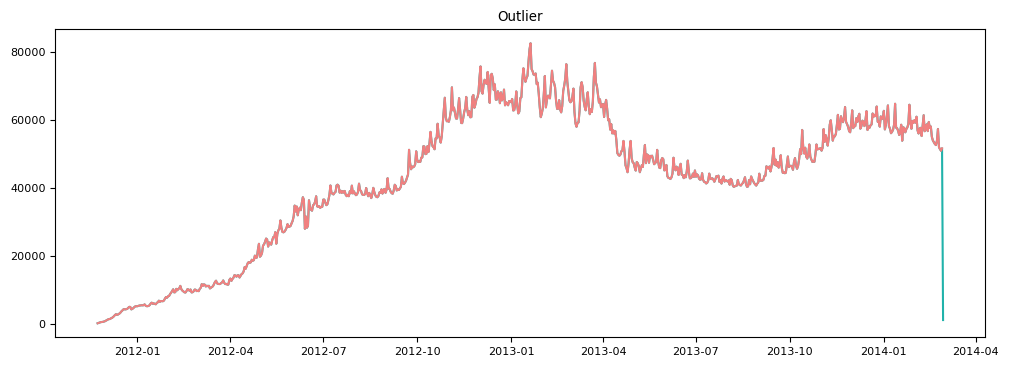

In [133]:
plt.plot(data['date'],data['energyuse'], color="lightseagreen")
plt.plot(data['date'][:-1],data['energyuse'][:-1], color="lightcoral")
plt.title("Outlier")
plt.show()

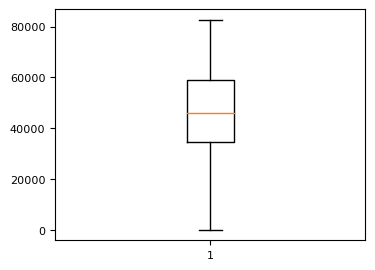

In [134]:
# 이상치를 제거했을 때
plt.figure(figsize=(4,3))
plt.boxplot(data['energyuse'][:-1])
plt.show()

#### Sunrise, Sunset time 차이와 energyuse의 연관성

In [139]:
final = pd.concat([pd.DataFrame(data['date'][:-1]),final_data[:-1]], axis=1)

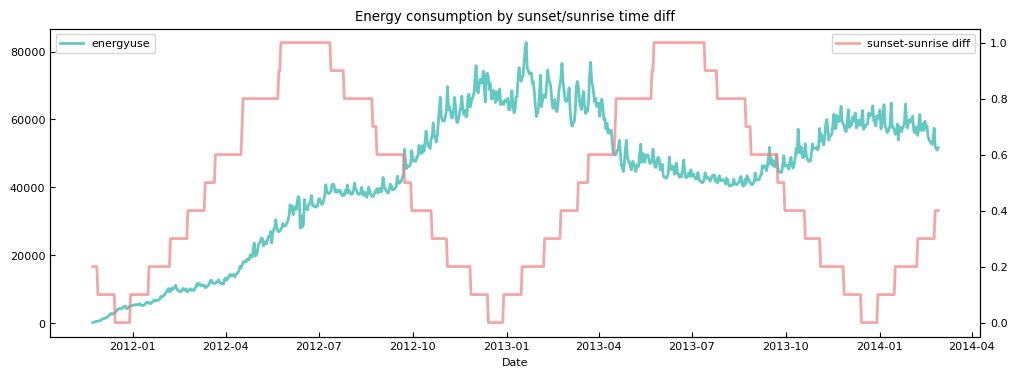

In [142]:
# 1. 기본 스타일 설정
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['font.size'] = 8

# 2. 데이터 준비
x = np.array(list(final['date']))
y1 = np.array(list(final['energyuse']))
y2 = np.array(list(final['sunset_sunrise_diff']))

# 3. 그래프 그리기
fig, ax1 = plt.subplots()

ax1.plot(x, y1, color='lightseagreen', markersize=3, linewidth=2, alpha=0.7, label='energyuse')
ax1.set_xlabel('Date')
ax1.tick_params(axis='both', direction='in')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='lightcoral', markersize=3, linewidth=2, alpha=0.7, label='sunset-sunrise diff')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Energy consumption by sunset/sunrise time diff')
plt.show()

#### energyuse acf, pacf 그래프

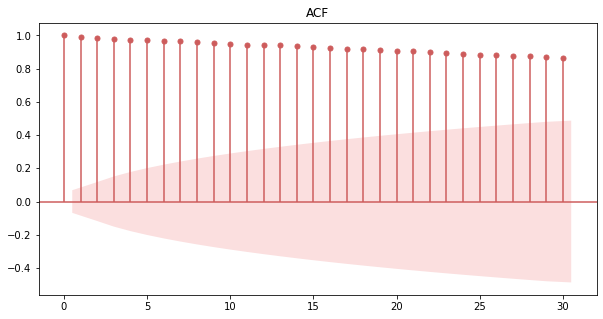

In [150]:
curr_fig, curr_ax = plt.subplots(figsize=(10, 5))
plot_acf(final['energyuse'], ax=curr_ax, color="indianred", vlines_kwargs={"colors": "indianred"})
for item in curr_ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("lightcoral")
plt.title("ACF");

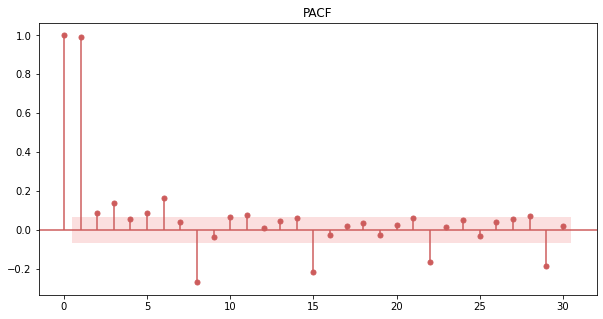

In [151]:
curr_fig, curr_ax = plt.subplots(figsize=(10, 5))
plot_pacf(final['energyuse'], ax=curr_ax, color="indianred", vlines_kwargs={"colors": "indianred"})
for item in curr_ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("lightcoral")
plt.title("PACF");

### 3. 모델링 (1) energyuse 변수만 사용한 경우

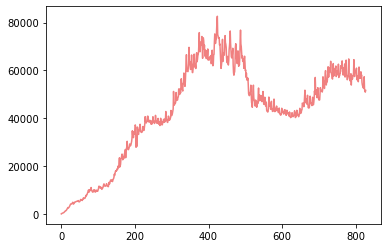

In [154]:
#에너지 변수만 가져오기
final_data = final_data[:-1]
energy=pd.DataFrame(final_data['energyuse'])
energy['energyuse'].plot(color="lightcoral");

- train, test set 분리

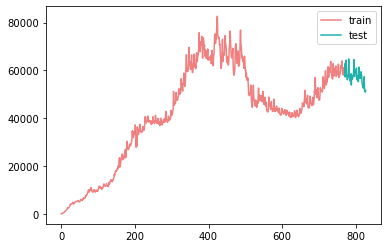

In [155]:
train = energy.iloc[:770]
test = energy.iloc[770:]

ax = train.plot(color="lightcoral")
test.plot(ax=ax, color="lightseagreen")
plt.legend(['train', 'test']);

- shift 변수 만들기

In [156]:
for s in range(1, 8):
    train['shift_{}'.format(s)] = train['energyuse'].shift(s)
    test['shift_{}'.format(s)] = test['energyuse'].shift(s)

train.head(8)

<ipython-input-156-cbc5f4f29de3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['shift_{}'.format(s)] = train['energyuse'].shift(s)
<ipython-input-156-cbc5f4f29de3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['shift_{}'.format(s)] = test['energyuse'].shift(s)


,energyuse,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
0,90.385000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,213.412000,90.385000,NaN,NaN,NaN,NaN,NaN,NaN
2,303.993000,213.412000,90.385000,NaN,NaN,NaN,NaN,NaN
3,420.976000,303.993000,213.412000,90.385000,NaN,NaN,NaN,NaN
4,444.883001,420.976000,303.993000,213.412000,90.385,NaN,NaN,NaN
5,500.686000,444.883001,420.976000,303.993000,213.412,90.385,NaN,NaN
6,584.317001,500.686000,444.883001,420.976000,303.993,213.412,90.385,NaN
7,669.827000,584.317001,500.686000,444.883001,420.976,303.993,213.412,90.385


In [ ]:
# train.dropna().to_csv('train_shift7.csv', index=False)
# test.dropna().to_csv('test_shift7.csv', index=False)

In [157]:
# na가 있는 항은 빼고 train, test set 분리
train_x = train.dropna().drop('energyuse', axis=1)
train_y = train.dropna()[['energyuse']]

test_x = test.dropna().drop('energyuse', axis=1)
test_y = test.dropna()[['energyuse']]

train_x.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
7,584.317001,500.686000,444.883001,420.976000,303.993000,213.412000,90.385000
8,669.827000,584.317001,500.686000,444.883001,420.976000,303.993000,213.412000
9,848.949001,669.827000,584.317001,500.686000,444.883001,420.976000,303.993000
10,1014.591001,848.949001,669.827000,584.317001,500.686000,444.883001,420.976000
11,1185.830000,1014.591001,848.949001,669.827000,584.317001,500.686000,444.883001


#### [1st layer]

#### 1) Random forest

In [192]:
rf = RandomForestRegressor(random_state=42, n_estimators=50)

rf.fit(train_x, train_y)
y_pred_rf_test = rf.predict(test_x)

<ipython-input-192-e8644724326b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_x, train_y)


In [193]:
rmse_rf=mean_squared_error(test_y, y_pred_rf_test)**0.5 # RMSE
rmse_rf

2714.8219031406543

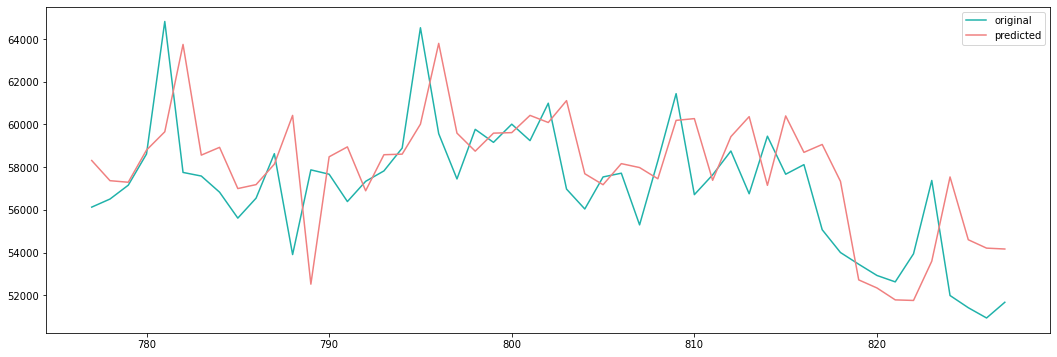

In [194]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_rf_test)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

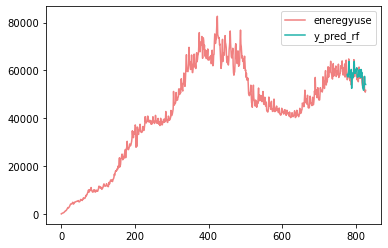

In [195]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_rf_test, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'y_pred_rf']);

#### 2) xgboost

In [164]:
xgbt = xgb.XGBRegressor(n_estimators=1000)
xgbt.fit(train_x, train_y,
        eval_set=[(train_x, train_y), (test_x, test_y)],
        early_stopping_rounds=50,
       verbose=3) 

[0]	validation_0-rmse:32917.49219	validation_1-rmse:38809.02734
[3]	validation_0-rmse:11615.56738	validation_1-rmse:13261.07422
[6]	validation_0-rmse:4382.89795	validation_1-rmse:4769.63916
[9]	validation_0-rmse:2071.65869	validation_1-rmse:2941.78052
[12]	validation_0-rmse:1367.50647	validation_1-rmse:2672.97266
[15]	validation_0-rmse:1078.01392	validation_1-rmse:2790.03223
[18]	validation_0-rmse:935.03565	validation_1-rmse:2888.21680
[21]	validation_0-rmse:857.80182	validation_1-rmse:2873.27515
[24]	validation_0-rmse:768.11554	validation_1-rmse:2871.78052
[27]	validation_0-rmse:709.86475	validation_1-rmse:2858.86035
[30]	validation_0-rmse:653.14783	validation_1-rmse:2855.51123
[33]	validation_0-rmse:583.94940	validation_1-rmse:2883.85644
[36]	validation_0-rmse:538.72101	validation_1-rmse:2884.75366
[39]	validation_0-rmse:473.27832	validation_1-rmse:2894.28589
[42]	validation_0-rmse:431.41486	validation_1-rmse:2895.17725
[45]	validation_0-rmse:401.52920	validation_1-rmse:2912.39966
[4

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [196]:
y_pred_xgb_test  = xgbt.predict(test_x)
rmse_xgb=mean_squared_error(test_y, y_pred_xgb_test)**0.5 # RMSE
rmse_xgb

2669.1432521649326

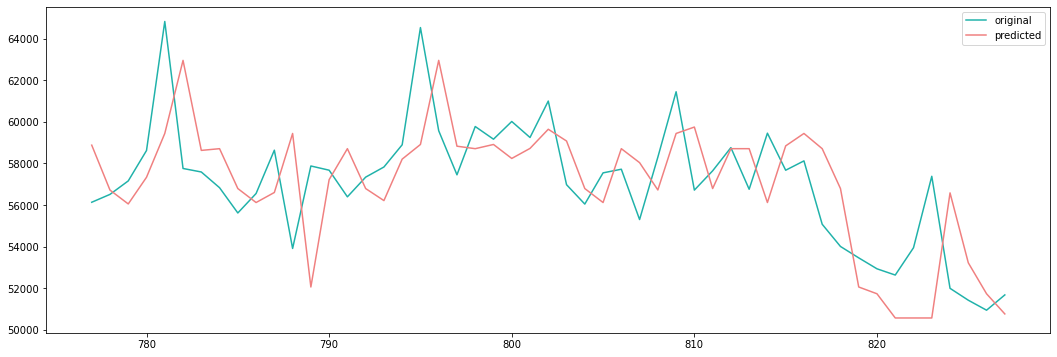

In [197]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_xgb_test)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

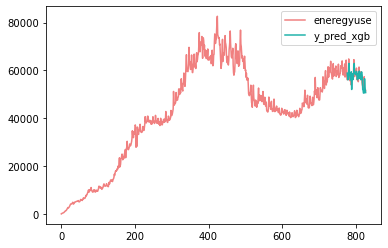

In [198]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_xgb_test, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'y_pred_xgb']);

#### 3) GA

In [169]:
#Genetic programming: Symbolic Regression
# add the new function to the function_set
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan']
ga = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=30, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                          feature_names=train_x.columns)
ga.fit(train_x, train_y)


print ('Score: ',metrics.mean_squared_error(test_y, ga.predict(test_x)))
print (ga._program)

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.13      1.43762e+15       10          1359.84          1995.08      1.43m
   1     8.38      7.18841e+10        8          1366.05          1932.15      1.40m
   2     7.25      3.82763e+07        3          1358.46          2007.41      1.32m
   3     7.75      2.43773e+10        9          1354.39          2050.47      1.24m
   4     8.46      1.42471e+15       12          1355.35          2034.42      1.26m
   5     8.78      8.94232e+09        1          1361.31          1981.97      1.19m
   6     9.52      2.45806e+10        5          1348.49           2096.2      1.26m
   7    10.13      2.40035e+10        1          1349.95           2083.2      1.15m
   8    10.35      4.81319e+10       12          1353.14          2054.77  

In [199]:
y_pred_ga_test  = ga.predict(test_x)

In [200]:
rmse_ga = np.sqrt(metrics.mean_squared_error(test_y, y_pred_ga_test))
rmse_ga

2543.396184140465

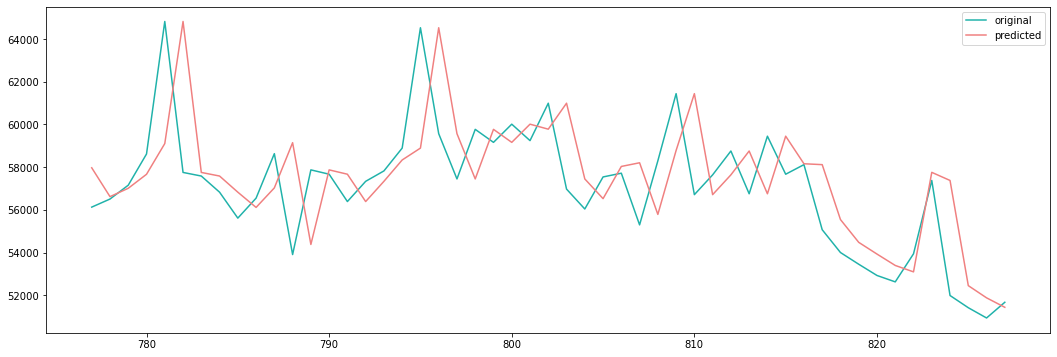

In [201]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_ga_test)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

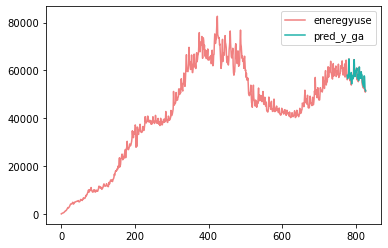

In [202]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_ga_test, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'pred_y_ga']);

#### 4) LSTM

lstm 입력에 맞는 형태로 데이터 변형

In [174]:
train_x_t = train_x.values
test_x_t = test_x.values
train_y_t = train_y.values
test_y_t = test_y.values

print(train_x_t.shape)
print(train_y_t.shape)

(763, 7)
(763, 1)


In [175]:
train_x_t = train_x_t.reshape(train_x_t.shape[0], 7, 1)
test_x_t = test_x_t.reshape(test_x.shape[0], 7, 1)

In [176]:
model1 = Sequential() # Sequeatial Model 
model1.add(LSTM(units=128, input_shape=(7, 1), activation="relu", return_sequences=True)) # (timestep, feature)
model1.add(Dropout(0.2))
model1.add(LSTM(64, activation="relu", return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(1)) # output = 1 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [177]:
model1.compile(loss='mean_squared_error', optimizer='adam') 

In [178]:
#history = model1.fit(train_x_t, train_y_t, epochs=50, batch_size=30)

In [22]:
#model1.save('lstm_shift_1204.h5')

In [179]:
model1 = load_model('lstm_shift_1204.h5')

In [181]:
rmse_lstm = np.sqrt(model1.evaluate(test_x_t, test_y, batch_size=30))
rmse_lstm

2/2 [==============================] - 0s 7ms/step - loss: 12194073.0000


3492.001288659556

In [203]:
y_pred_lstm_test = model1.predict(test_x_t)

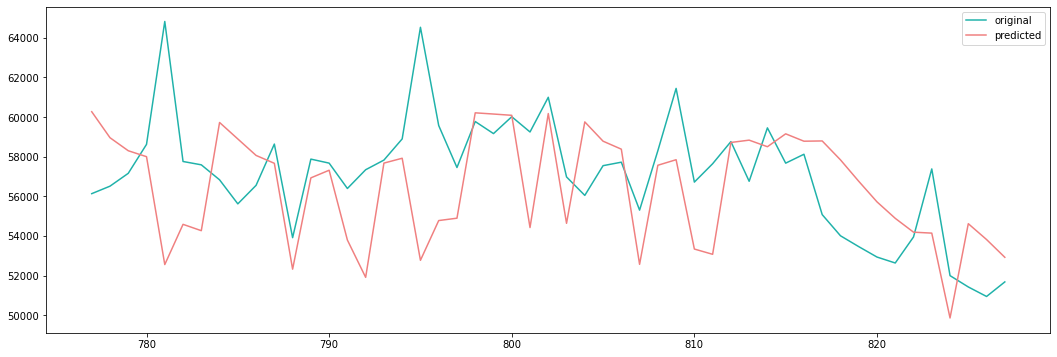

In [204]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_lstm_test)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

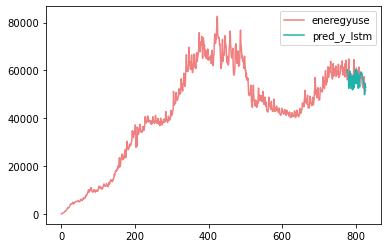

In [205]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_lstm_test, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'pred_y_lstm']);

In [255]:
# 결과표
pd.DataFrame({'method':['rf', 'xgb', 'ga', 'lstm'],
             'rmse':[rmse_rf, rmse_xgb, rmse_ga, rmse_lstm]})

,method,rmse
0,rf,2714.821903
1,xgb,2669.143252
2,ga,2543.396184
3,lstm,3492.001289


#### [2nd layer] stacking

- 2nd layer에 필요한 dataframe 생성

In [191]:
# train data prediction
y_pred_rf = rf.predict(train_x)  
y_pred_xgb = xgbt.predict(train_x)
y_pred_ga = ga.predict(train_x)
lstm_model= load_model('lstm_shift_1204.h5')
y_pred_lstm =model1.predict(train_x_t)

In [210]:
#stacking train_x
tt=[]
for i in range(len(y_pred_lstm)):
    tt.append(float(y_pred_lstm[i]))

tt = np.array(tt)
y_pred_lstm = tt

stack_train_x = tf.stack([y_pred_rf,y_pred_xgb,y_pred_ga,y_pred_lstm],axis=0)
stack_train_x = pd.DataFrame(stack_train_x).astype("float").T
stack_train_x.head(5)

,0,1,2,3
0,775.79454,687.376892,584.317001,459.221436
1,864.38908,835.454590,669.827000,530.036621
2,957.91072,1040.613281,848.949001,642.152039
3,1155.81952,1154.007324,1014.591001,779.185547
4,1294.20452,1314.078247,1185.830000,925.171265


In [206]:
#stacking test_x
tt=[]
for i in range(len(y_pred_lstm_test)):
  tt.append(float(y_pred_lstm_test[i]))

tt = np.array(tt)
y_pred_lstm_test = tt

stack_test_x = tf.stack([y_pred_rf_test,y_pred_xgb_test,y_pred_ga_test,y_pred_lstm_test],axis=0)
stack_test_x = pd.DataFrame(stack_test_x).astype("float").T
stack_test_x.head(5)

,0,1,2,3
0,58312.738561,58875.734375,57972.302180,60266.242188
1,57368.691158,56714.898438,56621.368869,58954.246094
2,57295.465177,56050.496094,57013.013359,58297.386719
3,58800.845617,57332.113281,57667.896020,57997.242188
4,59657.228718,59437.601562,59106.048699,52553.578125


In [211]:
#stack_test_x = pd.read_csv("stack_test_x.csv")
#stack_train_x = pd.read_csv("stack_train_x.csv")

In [215]:
ada = AdaBoostRegressor(ExtraTreeRegressor(max_depth= 76,max_features= 'sqrt', min_samples_leaf= 4,min_samples_split=10, random_state=42),learning_rate=0.5)

ada.fit(stack_train_x, train_y)
pred_ada2 = ada.predict(stack_test_x)

rmse_ada2=np.sqrt(mean_squared_error(test_y, pred_ada2))
rmse_ada2

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2781.632590277837

In [213]:
grad = GradientBoostingRegressor(learning_rate=0.9,
                                 n_estimators=1000, min_samples_split=3,max_depth=40)

grad.fit(stack_train_x, train_y)
pred_grad = grad.predict(stack_test_x)

rmse_grad=np.sqrt(mean_squared_error(test_y, pred_grad))
rmse_grad

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2839.9081556071633

In [219]:
xt = ExtraTreesRegressor(max_depth= 76,max_features= 'sqrt',
                                min_samples_leaf= 4,min_samples_split=10,n_estimators= 531, random_state=42)
xt.fit(stack_train_x, train_y)
pred_xt = xt.predict(stack_test_x)

rmse_xt=np.sqrt(mean_squared_error(test_y, pred_xt))
rmse_xt

<ipython-input-219-1a693fa68a53>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xt.fit(stack_train_x, train_y)


2601.979726823981

In [220]:
avglist=[]
for i in range(len(stack_test_x)):
  m = np.mean(stack_test_x.iloc[i])
  avglist.append(m)

mean_pred = pd.DataFrame(avglist)

rmse_mean=np.sqrt(mean_squared_error(test_y, mean_pred))
rmse_mean

2293.042699864018

In [221]:
# 결과표
pd.DataFrame({'method':['AdaBoost', 'GradientBoost', 'ExtraTree', '평균'],
             'rmse':[rmse_ada2, rmse_grad, rmse_xt, rmse_mean]})

,method,rmse
0,AdaBoost,2781.632590
1,GradientBoost,2839.908156
2,ExtraTree,2601.979727
3,평균,2293.042700


In [294]:
# rmse 시각화
basedf1=pd.DataFrame({'method':['rf', 'xgb', 'ga', 'lstm'],
                     'rmse':[rmse_rf, rmse_xgb, rmse_ga, rmse_lstm],
                     'layer':['1st', '1st', '1st', '1st']})
stackdf1=pd.DataFrame({'method':['AdaBoost', 'GradientBoost', 'ExtraTree', 'mean'],
                     'rmse':[rmse_ada2, rmse_grad, rmse_xt, rmse_mean],
                      'layer':['2nd', '2nd', '2nd', '2nd']})

df1 = pd.concat([basedf1, stackdf1], axis=0)
df1

,method,rmse,layer
0,rf,2714.821903,1st
1,xgb,2669.143252,1st
2,ga,2543.396184,1st
3,lstm,3492.001289,1st
0,AdaBoost,2781.632590,2nd
1,GradientBoost,2839.908156,2nd
2,ExtraTree,2601.979727,2nd
3,mean,2293.042700,2nd


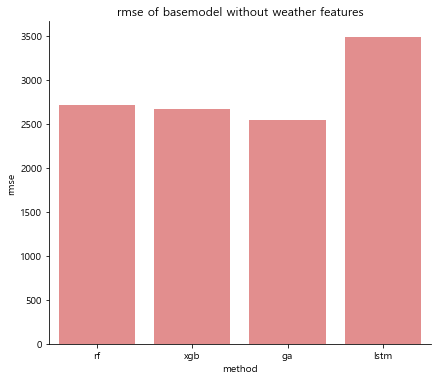

In [280]:
sns.catplot(x='method', y='rmse', data=basedf1, kind='bar', 
            height=5, aspect=1.2, color='lightcoral')
plt.title("rmse of basemodel without weather features");

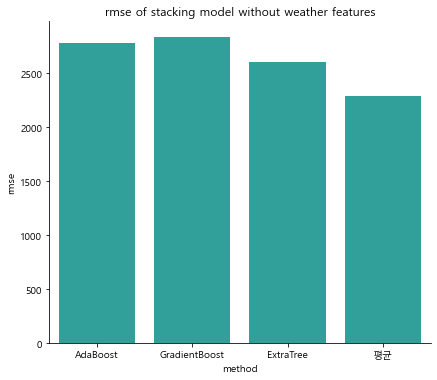

In [281]:
sns.catplot(x='method', y='rmse', data=stackdf1, kind='bar', 
            height=5, aspect=1.2, color='lightseagreen')
plt.title("rmse of stacking model without weather features");

### 4. 모델링 (2) weather 변수를 추가한 경우

- weather 변수를 추가한 dataframe

In [222]:
final_data=pd.read_csv('timeSeries_final.csv')[:-1]

train_w = final_data.iloc[:770]
test_w = final_data.iloc[770:]
train_w.head()

#shift 변수 추가
for s in range(1, 8):
    train_w['shift_{}'.format(s)] = train_w['energyuse'].shift(s)
    test_w['shift_{}'.format(s)] = test_w['energyuse'].shift(s)
    
# na가 있는 항은 빼고 train, test set 분리
train_x_w = train_w.dropna().drop('energyuse', axis=1)
train_y_w = train_w.dropna()[['energyuse']]

test_x_w = test_w.dropna().drop('energyuse', axis=1)
test_y_w = test_w.dropna()[['energyuse']]

train_x_w.head()

<ipython-input-222-a6140db5bc83>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_w['shift_{}'.format(s)] = train_w['energyuse'].shift(s)
<ipython-input-222-a6140db5bc83>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_w['shift_{}'.format(s)] = test_w['energyuse'].shift(s)


,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,apparentTemperatureMax,temperatureMin,...,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_wind,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
7,0.367529,0.571031,0.511519,0.31,0.433402,0.651532,0.834776,0.636364,0.437449,0.457601,...,0,0,1,584.317001,500.686000,444.883001,420.976000,303.993000,213.412000,90.385000
8,0.376155,0.626741,0.574385,0.57,0.242828,0.451922,0.769841,0.709091,0.445114,0.447670,...,1,0,0,669.827000,584.317001,500.686000,444.883001,420.976000,303.993000,213.412000
9,0.250462,0.646240,0.450215,0.32,0.286885,0.532998,0.751082,0.800000,0.258418,0.313216,...,0,0,1,848.949001,669.827000,584.317001,500.686000,444.883001,420.976000,303.993000
10,0.353666,0.688022,0.563061,0.54,0.534836,0.394033,0.809524,0.654545,0.425130,0.525592,...,1,0,0,1014.591001,848.949001,669.827000,584.317001,500.686000,444.883001,420.976000
11,0.282502,0.707521,0.496291,0.36,0.421107,0.355116,0.857143,0.709091,0.294826,0.394576,...,1,0,0,1185.830000,1014.591001,848.949001,669.827000,584.317001,500.686000,444.883001


#### [1st layer]

#### 1) Random forest

In [223]:
rf2 = RandomForestRegressor(random_state=42, n_estimators=50)

rf2.fit(train_x_w, train_y_w)
y_pred_rf_w = rf2.predict(train_x_w)  

<ipython-input-223-e6c17738151e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf2.fit(train_x_w, train_y_w)


In [224]:
y_pred_rf_test_w = rf2.predict(test_x_w)

In [229]:
rmse2_rf=mean_squared_error(test_y, y_pred_rf_test_w)**0.5 # RMSE
rmse2_rf

2692.4219809054816

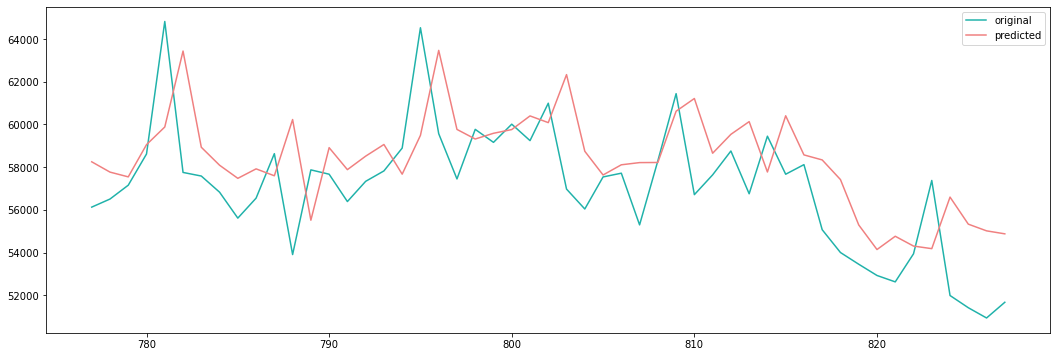

In [225]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_rf_test_w)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

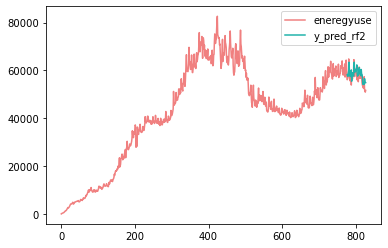

In [226]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_rf_test_w, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'y_pred_rf2']);

#### 2) xgboost

In [231]:
xgbt2 = xgb.XGBRegressor(n_estimators=1000)
xgbt2.fit(train_x_w, train_y_w,
        eval_set=[(train_x_w, train_y_w), (test_x_w, test_y_w)],
        early_stopping_rounds=50, verbose=3) 
y_pred_xgb_w = xgbt2.predict(train_x_w)

[0]	validation_0-rmse:32917.49219	validation_1-rmse:38809.02734
[3]	validation_0-rmse:11606.28711	validation_1-rmse:13125.77734
[6]	validation_0-rmse:4303.93213	validation_1-rmse:4228.03027
[9]	validation_0-rmse:1877.49536	validation_1-rmse:2591.74951
[12]	validation_0-rmse:1061.28943	validation_1-rmse:2469.20337
[15]	validation_0-rmse:759.62982	validation_1-rmse:2550.73608
[18]	validation_0-rmse:624.90027	validation_1-rmse:2625.28101
[21]	validation_0-rmse:529.28546	validation_1-rmse:2650.10693
[24]	validation_0-rmse:435.18570	validation_1-rmse:2696.54810
[27]	validation_0-rmse:362.39365	validation_1-rmse:2725.07837
[30]	validation_0-rmse:313.97717	validation_1-rmse:2761.80103
[33]	validation_0-rmse:285.55994	validation_1-rmse:2768.37036
[36]	validation_0-rmse:255.30577	validation_1-rmse:2770.26025
[39]	validation_0-rmse:230.54468	validation_1-rmse:2761.21631
[42]	validation_0-rmse:211.29088	validation_1-rmse:2762.37451
[45]	validation_0-rmse:191.65561	validation_1-rmse:2761.58765
[48

In [232]:
y_pred_xgb_test_w = xgbt2.predict(test_x_w)

In [233]:
rmse2_xgb=mean_squared_error(test_y, y_pred_xgb_test_w)**0.5 # RMSE
rmse2_xgb

2469.203345501416

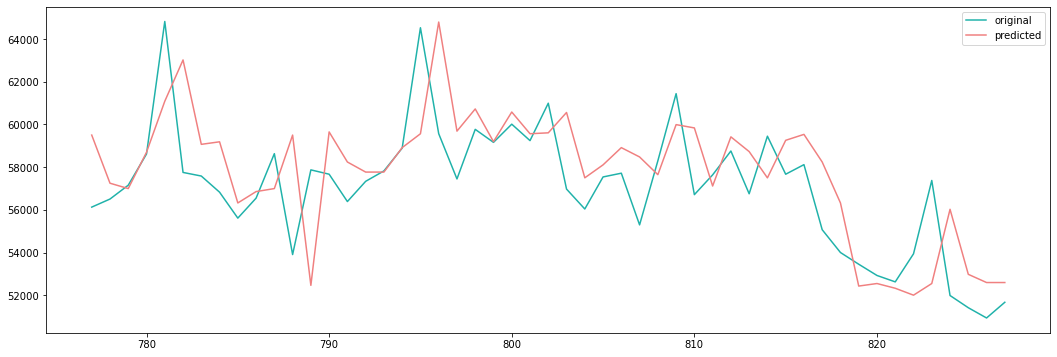

In [234]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_xgb_test_w)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

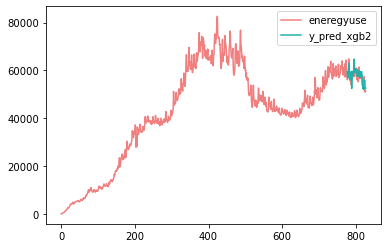

In [235]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_xgb_test_w, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'y_pred_xgb2']);

#### 3) GA

In [237]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos', 'tan']

ga2 = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=30, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9,parsimony_coefficient=0.01, random_state=0,
                          feature_names=train_x_w.columns)

ga2.fit(train_x_w, train_y_w)

y_pred_ga_w = ga2.predict(train_x_w)

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [238]:
y_pred_ga_test_w = ga2.predict(test_x_w)

In [240]:
rmse2_ga=mean_squared_error(test_y, y_pred_ga_test_w)**0.5 # RMSE
rmse2_ga

2622.9582247961603

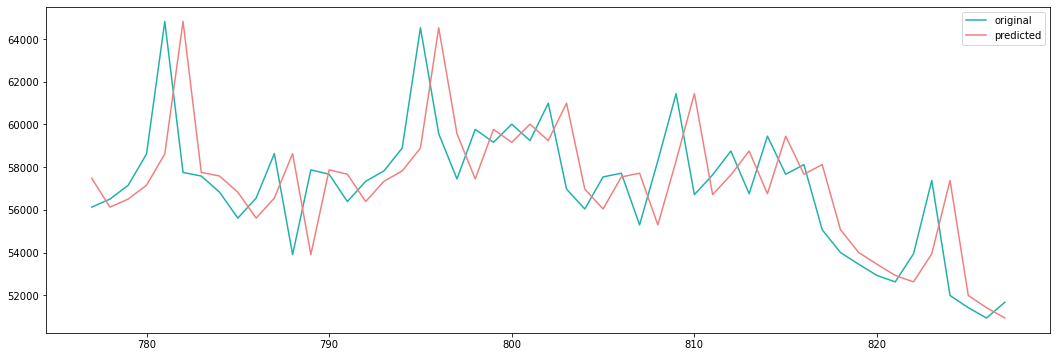

In [241]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_ga_test_w)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

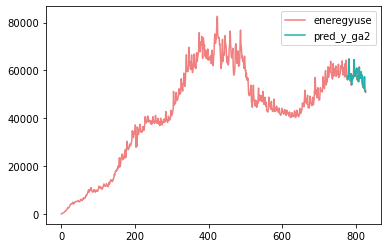

In [242]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_ga_test_w, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'pred_y_ga2']);

#### 4) LSTM

In [243]:
train_x_t = train_x_w.values
test_x_t = test_x_w.values
train_y_t = train_y_w.values
test_y_t = test_y_w.values

print(train_x_t.shape)
print(train_y_t.shape)

(763, 28)
(763, 1)


In [244]:
train_x_t = train_x_t.reshape(train_x_t.shape[0], 28, 1)
test_x_t = test_x_t.reshape(test_x_t.shape[0], 28, 1)

In [245]:
model2 = Sequential() # Sequeatial Model 
model2.add(LSTM(units=128, input_shape=(28, 1), activation="relu", return_sequences=True)) # (timestep, feature)
model2.add(Dropout(0.2))
model2.add(LSTM(64, activation="relu", return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(1)) # output = 1 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 28, 128)           66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [246]:
model2.compile(loss='mean_squared_error', optimizer='adam') 

In [247]:
#history = model2.fit(train_x_t, train_y, epochs=50, batch_size=30)

In [248]:
#model2.save('lstm_shift+weather_1204.h5')
model2 = load_model('lstm_shift+weather_1204.h5')

In [250]:
y_pred_lstm_w =model2.predict(train_x_t)
y_pred_lstm_test_w = model2.predict(test_x_t)

In [252]:
rmse2_lstm = mean_squared_error(test_y, y_pred_lstm_test_w)**0.5 # RMSE
print(rmse2_lstm)

2666.658215944736


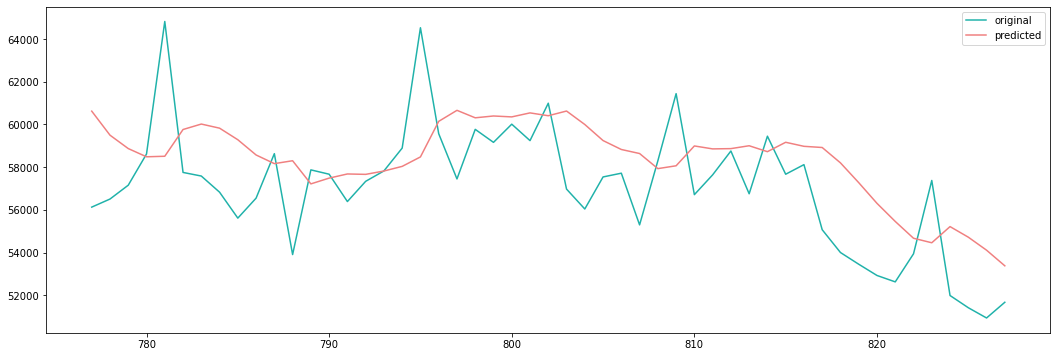

In [253]:
df_train = pd.DataFrame(train_y)
df_train.columns = ['energyuse']
df_pred = pd.DataFrame(y_pred_lstm_test_w)
df_pred.index = range(777,828)
df_pred.columns = ['energyuse']
df_test = pd.DataFrame(test_y)
df_y_test = pd.concat([df_train, df_test], axis=0)
df_y_pred = pd.concat([df_train, df_pred], axis=0)

fig = plt.figure(figsize = (18, 6))
chart = fig.add_subplot(1,1,1)
chart.plot(df_test['energyuse'], color='lightseagreen' , label='original')
chart.plot(df_pred['energyuse'], color='lightcoral' , label='predicted')
plt.legend(loc = 'best')
plt.show()

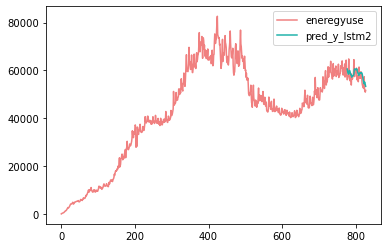

In [254]:
ax = energy['energyuse'].plot(color="lightcoral")
pd.DataFrame(y_pred_lstm_test_w, index=list(range(777,828))).plot(ax=ax, color="lightseagreen")
plt.legend(['eneregyuse', 'pred_y_lstm2']);

In [256]:
# 결과표
pd.DataFrame({'method':['rf', 'xgb', 'ga', 'lstm'],
             'rmse':[rmse2_rf, rmse2_xgb, rmse2_ga, rmse2_lstm]})

,method,rmse
0,rf,2692.421981
1,xgb,2469.203346
2,ga,2622.958225
3,lstm,2666.658216


#### [2nd layer] stacking

- 2nd layer에 필요한 dataframe 생성

In [268]:
#stacking train_x
tt=[]
for i in range(len(y_pred_lstm_w)):
    tt.append(float(y_pred_lstm_w[i]))

tt = np.array(tt)
y_pred_lstm_w = tt

stack_train_x_w = tf.stack([y_pred_rf_w,y_pred_xgb_w,y_pred_ga_w,y_pred_lstm_w],axis=0)
stack_train_x_w = pd.DataFrame(stack_train_x_w).astype("float").T
stack_train_x_w.head(5)

,0,1,2,3
0,843.79744,718.494507,584.317001,492.869415
1,939.50334,868.115601,669.827000,565.150574
2,1159.35234,1047.394043,848.949001,649.404602
3,1136.18766,1176.167480,1014.591001,755.309326
4,1301.99676,1336.238403,1185.830000,873.757935


In [269]:
#stacking test_x
tt=[]
for i in range(len(y_pred_lstm_test_w)):
    tt.append(float(y_pred_lstm_test_w[i]))

tt = np.array(tt)
y_pred_lstm_test_w = tt

stack_test_x_w = tf.stack([y_pred_rf_test_w,y_pred_xgb_test_w,y_pred_ga_test_w,y_pred_lstm_test_w],axis=0)
stack_test_x_w = pd.DataFrame(stack_test_x_w).astype("float").T
stack_test_x_w.head(5)

,0,1,2,3
0,58252.062237,59503.292969,57479.259990,60622.972656
1,57770.116237,57250.296875,56131.369998,59498.554688
2,57547.078278,56999.246094,56509.663004,58871.628906
3,59055.015338,58699.289062,57157.208998,58486.847656
4,59881.569438,61085.390625,58618.008008,58511.695312


In [275]:
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3,max_features='sqrt',max_leaf_nodes=870,min_samples_leaf=8),n_estimators=500,learning_rate=0.5)

ada.fit(stack_train_x_w, train_y)
pred_ada_w = ada.predict(stack_test_x_w)

rmse_ada_w=np.sqrt(mean_squared_error(test_y, pred_ada_w))
rmse_ada_w

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2594.1757138224816

In [271]:
grad = GradientBoostingRegressor(learning_rate=0.9,
                                 n_estimators=1000, min_samples_split=3,max_depth=40)

grad.fit(stack_train_x_w, train_y)
pred_grad_w = grad.predict(stack_test_x_w)

rmse_grad_w=np.sqrt(mean_squared_error(test_y, pred_grad_w))
rmse_grad_w

C:\Users\YJ-HWANG\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


2530.2938652654707

In [272]:
xt = ExtraTreesRegressor(max_depth= 76,max_features= 'sqrt',
                                min_samples_leaf= 4,min_samples_split=10,n_estimators= 531, random_state=42)
xt.fit(stack_train_x_w, train_y)
pred_xt_w = xt.predict(stack_test_x_w)

rmse_xt_w = np.sqrt(mean_squared_error(test_y, pred_xt_w))
rmse_xt_w

<ipython-input-272-40bdfe001007>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xt.fit(stack_train_x_w, train_y)


2538.888722509529

In [273]:
avglist=[]
for i in range(len(stack_test_x_w)):
  m = np.mean(stack_test_x_w.iloc[i])
  avglist.append(m)

mean_pred_w = pd.DataFrame(avglist)

rmse_mean_w = np.sqrt(mean_squared_error(test_y, mean_pred_w))
rmse_mean_w

2413.5765954600465

In [276]:
# 결과표
pd.DataFrame({'method':['AdaBoost', 'GradientBoost', 'ExtraTree', '평균'],
              'rmse_with weather': [rmse_ada_w, rmse_grad_w, rmse_xt_w, rmse_mean_w]})

,method,rmse_with weather
0,AdaBoost,2594.175714
1,GradientBoost,2530.293865
2,ExtraTree,2538.888723
3,평균,2413.576595


In [293]:
# rmse 시각화
basedf2=pd.DataFrame({'method':['rf', 'xgb', 'ga', 'lstm'],
                     'rmse':[rmse2_rf, rmse2_xgb, rmse2_ga, rmse2_lstm],
                     'layer':['1st', '1st', '1st', '1st']})
stackdf2=pd.DataFrame({'method':['AdaBoost', 'GradientBoost', 'ExtraTree', 'mean'],
                     'rmse':[rmse_ada_w, rmse_grad_w, rmse_xt_w, rmse_mean_w],
                      'layer':['2nd', '2nd', '2nd', '2nd']})

df2 = pd.concat([basedf2, stackdf2], axis=0)
df2

,method,rmse,layer
0,rf,2692.421981,1st
1,xgb,2469.203346,1st
2,ga,2622.958225,1st
3,lstm,2666.658216,1st
0,AdaBoost,2594.175714,2nd
1,GradientBoost,2530.293865,2nd
2,ExtraTree,2538.888723,2nd
3,mean,2413.576595,2nd


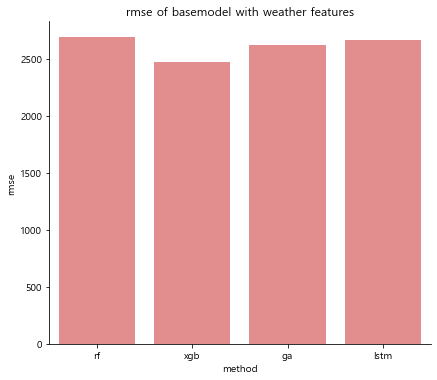

In [282]:
sns.catplot(x='method', y='rmse', data=basedf2, kind='bar', 
            height=5, aspect=1.2, color='lightcoral')
plt.title("rmse of basemodel with weather features");

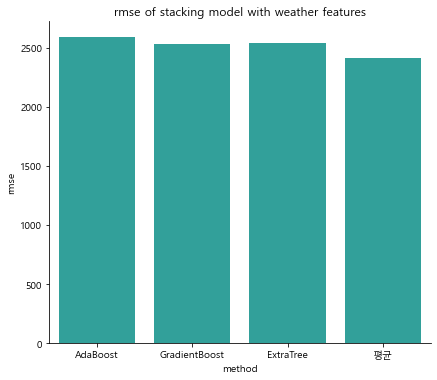

In [283]:
sns.catplot(x='method', y='rmse', data=stackdf2, kind='bar', 
            height=5, aspect=1.2, color='lightseagreen')
plt.title("rmse of stacking model with weather features");

In [295]:
df1['features'] = 'without_weather'
df2['features'] = 'with_weather'
df = pd.concat([df1, df2], axis=0)
df

,method,rmse,layer,features
0,rf,2714.821903,1st,without_weather
1,xgb,2669.143252,1st,without_weather
2,ga,2543.396184,1st,without_weather
3,lstm,3492.001289,1st,without_weather
0,AdaBoost,2781.632590,2nd,without_weather
1,GradientBoost,2839.908156,2nd,without_weather
2,ExtraTree,2601.979727,2nd,without_weather
3,mean,2293.042700,2nd,without_weather
0,rf,2692.421981,1st,with_weather
1,xgb,2469.203346,1st,with_weather


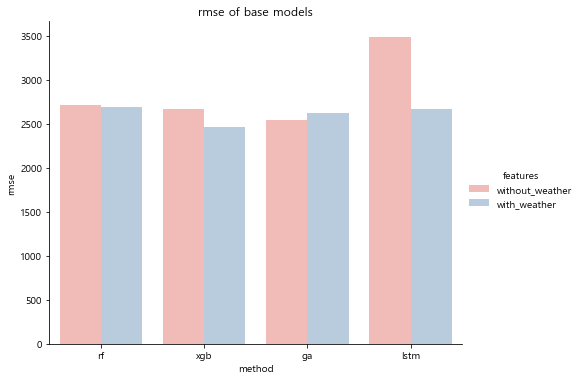

In [296]:
temp = df[df['layer']=='1st']
sns.catplot(x='method', y='rmse', data=temp,
           hue='features', kind='bar', height=5, aspect=1.3)
plt.title('rmse of base models');

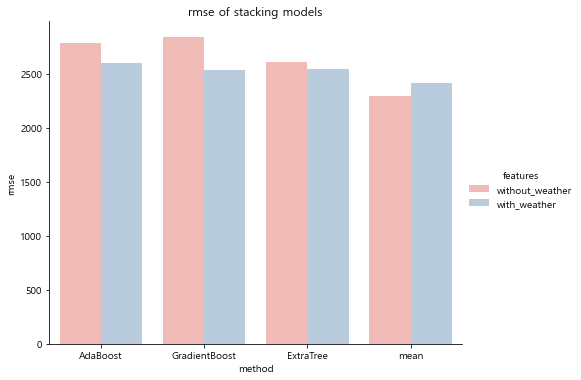

In [297]:
temp = df[df['layer']=='2nd']
sns.catplot(x='method', y='rmse', data=temp,
           hue='features', kind='bar', height=5, aspect=1.3)
plt.title('rmse of stacking models');